In [23]:
#テンプレート

# モジュールのインポート
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
import lightgbm as lgb
import optuna
import os
import datetime
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.model_selection import KFold  # 通常のK分割交差検証（今回使用）
from lightgbm import LGBMClassifier  # LightGBMのモデルクラス



# 読み込むデータが格納されたディレクトリのパス（※必要に応じて変更の必要があります）
PATH = '../data/'


X = pd.read_csv(PATH + 'train.csv')  # 学習用データの読み込み
test = pd.read_csv(PATH + 'test.csv')    # テスト用データの読み込み

In [24]:
# Ageの欠損補完と欠損フラグの追加（trainとtestの両方に適用）

# Xデータ
X["Age_filled"] = X["Age"].fillna(-1)
X["Age_missing"] = X["Age"].isna().astype(int)
X = X.drop(columns=["Age"])

# testデータ
test["Age_filled"] = test["Age"].fillna(-1)
test["Age_missing"] = test["Age"].isna().astype(int)
test = test.drop(columns=["Age"])

# 数値項目のうち欠損があるものを中央値で補完（X/test共通処理）

# 欠損がある列を自動検出して処理
for col in X.columns:
    if X[col].isna().sum() > 0:
        median = X[col].median()
        X[col] = X[col].fillna(median)
        test[col] = test[col].fillna(median)

In [25]:
X = X.drop(columns=["Id"])
test = test.drop(columns=["Id"])

In [26]:
# Drafted を目的変数として切り離し
y = X["Drafted"]
X = X.drop(columns=["Drafted"])

# School, Player_Type, Position_Type は使用しない場合は最初からdrop
X = X.drop(columns=["School", "Player_Type", "Position_Type"])
test = test.drop(columns=["School", "Player_Type", "Position_Type"])

# Position は Target Encoding + Group Encoding にのみ使用
# Label Encodingは不要


In [27]:
# PositionをTarget Encoding（全体平均ベース、これは許容範囲）
position_stats = X.copy()
position_stats["Drafted"] = y
position_target_map = position_stats.groupby("Position")["Drafted"].mean()
X["Position_encoded"] = X["Position"].map(position_target_map)
test["Position_encoded"] = test["Position"].map(position_target_map)
test["Position_encoded"] = test["Position_encoded"].fillna(X["Position_encoded"].mean())

# Position_groupを作成（これは合法・安全）
def map_position_group(pos):
    if pos in ["K", "P", "LS"]:
        return "Specialist"
    elif pos in ["WR", "RB", "TE"]:
        return "OffensiveSkill"
    elif pos in ["OT", "OG", "C"]:
        return "OffensiveLine"
    elif pos in ["DE", "DT"]:
        return "DefensiveLine"
    elif pos in ["OLB", "ILB"]:
        return "Linebacker"
    elif pos in ["CB", "FS", "SS", "S", "DB"]:
        return "DefensiveBack"
    elif pos == "QB":
        return "Quarterback"
    elif pos == "FB":
        return "Fullback"
    else:
        return "Other"

X["Position_group"] = X["Position"].apply(map_position_group)
test["Position_group"] = test["Position"].apply(map_position_group)

# fold-safeな target encoding を実施
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["Position_group_encoded"] = 0  # 初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    group_map = X_train.assign(Drafted=y_train).groupby("Position_group")["Drafted"].mean()
    X.loc[val_idx, "Position_group_encoded"] = X.loc[val_idx, "Position_group"].map(group_map)

# testデータには全体平均から算出（合法）
final_group_map = X.assign(Drafted=y).groupby("Position_group")["Drafted"].mean()
test["Position_group_encoded"] = test["Position_group"].map(final_group_map)
test["Position_group_encoded"] = test["Position_group_encoded"].fillna(X["Position_group_encoded"].mean())

# 不要な文字列列は削除（エラー防止）
X = X.drop(columns=["Position", "Position_group"])
test = test.drop(columns=["Position", "Position_group"])

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3887577351.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.6        0.2739726  0.65632458 0.7109375  0.62895928 0.62895928
 0.65632458 0.62895928 0.7109375  0.71884984 0.6        0.65632458
 0.65632458 0.71884984 0.62895928 0.62895928 0.65632458 0.71884984
 0.62895928 0.65632458 0.65632458 0.62895928 0.62895928 0.65632458
 0.6        0.62895928 0.62895928 0.65632458 0.71884984 0.7109375
 0.62895928 0.7109375  0.71884984 0.62895928 0.65632458 0.62895928
 0.2739726  0.65632458 0.65632458 0.2739726  0.68376068 0.65632458
 0.62895928 0.48275862 0.68376068 0.68376068 0.71884984 0.62895928
 0.62895928 0.62895928 0.7109375  0.62895928 0.71884984 0.65632458
 0.7109375  0.62895928 0.6        0.62895928 0.7109375  0.65632458
 0.62895928 0.62895928 0.71884984 0.71884984 0.68376068 0.7109375
 0.68376068 0.65632458 0.62895928 0.62895928 0.62895928 0.62895928
 

In [28]:
from sklearn.preprocessing import MinMaxScaler

# kg → lbs
X["Weight_lbs"] = X["Weight"] * 2.20462
test["Weight_lbs"] = test["Weight"] * 2.20462

# Speed Score
X["SpeedScore"] = X["Weight_lbs"] * (200 / X["Sprint_40yd"]**2)
test["SpeedScore"] = test["Weight_lbs"] * (200 / test["Sprint_40yd"]**2)

# Burst Score
X["BurstScore"] = X["Vertical_Jump"] + X["Broad_Jump"]
test["BurstScore"] = test["Vertical_Jump"] + test["Broad_Jump"]

# Agility Score
X["AgilityScore"] = X["Shuttle"] + X["Agility_3cone"]
test["AgilityScore"] = test["Shuttle"] + test["Agility_3cone"]

# ASI（Athletic Score Index）
X["ASI"] = (
    0.5 * X["SpeedScore"] +
    0.3 * X["BurstScore"] +
    0.2 * X["AgilityScore"]
)
test["ASI"] = (
    0.5 * test["SpeedScore"] +
    0.3 * test["BurstScore"] +
    0.2 * test["AgilityScore"]
)

# RSA スケーリング特徴量作成
rsa_features = ["Sprint_40yd", "Vertical_Jump", "Bench_Press_Reps", "Shuttle", "Agility_3cone"]

for col in rsa_features:
    scaler = MinMaxScaler(feature_range=(0, 10))
    if col in ["Sprint_40yd", "Shuttle", "Agility_3cone"]:
        X[f"RSA_{col}"] = 10 - scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = 10 - scaler.transform(test[[col]])
    else:
        X[f"RSA_{col}"] = scaler.fit_transform(X[[col]])
        test[f"RSA_{col}"] = scaler.transform(test[[col]])


In [29]:
# 学習に使いたい全特徴量を明示的にリストアップ
all_features = [
    'Year', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
    'Broad_Jump', 'Agility_3cone', 'Shuttle',
    'Position_encoded', 'Position_group_encoded', 'Age_filled', 'Age_missing',
    'ASI',  # ✅ 使用
    'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone'  # ✅ 使用
]

# 重複削除
all_features = list(dict.fromkeys(all_features))

print(all_features)

['Year', 'Height', 'Weight', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps', 'Broad_Jump', 'Agility_3cone', 'Shuttle', 'Position_encoded', 'Position_group_encoded', 'Age_filled', 'Age_missing', 'ASI', 'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone']


In [30]:
all_features = [
    'Year', 'Height', 'Weight', 'Broad_Jump',
    'Position_encoded', 'Position_group_encoded',
    'Age_filled', 'Age_missing',
    'ASI',  # RSAに基づく重要指標
    'RSA_Sprint_40yd', 'RSA_Vertical_Jump', 'RSA_Bench_Press_Reps', 'RSA_Shuttle', 'RSA_Agility_3cone'
]


In [31]:
X["BMI"] = X["Weight"] / (X["Height"]/100)**2
test["BMI"] = test["Weight"] / (test["Height"]/100)**2

all_features += ["BMI"]
all_features = list(dict.fromkeys(all_features))

# all_features から Weight, Height を削除
all_features = [col for col in all_features if col not in ["Weight", "Height"]]

all_features = [col for col in all_features if col != "Age_missing"]


all_features = [f for f in all_features if f != "BMI"]

if "Weight" not in all_features:
    all_features.append("Weight")
if "Height" not in all_features:
    all_features.append("Height")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

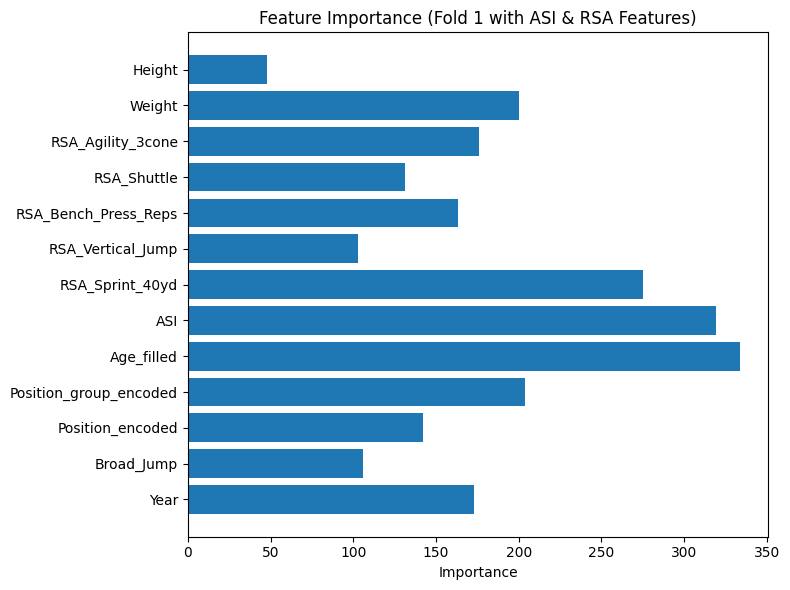

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

X_feat = X[all_features]
y_feat = y

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_feat)):
    X_train, X_valid = X_feat.iloc[train_idx], X_feat.iloc[valid_idx]
    y_train, y_valid = y_feat.iloc[train_idx], y_feat.iloc[valid_idx]
    
    model = LGBMClassifier(
        max_depth=4,
        num_leaves=10,
        min_child_samples=50,
        reg_alpha=5.0,
        reg_lambda=5.0,
        learning_rate=0.03,
        n_estimators=700,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)
    
    train_aucs.append(train_auc)
    val_aucs.append(val_auc)
    
    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_feat.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")

In [33]:
# 🚩 School 列を復元する（削除済の場合）
if "School" not in X.columns:
    df_raw = pd.read_csv("../data/train.csv")
    X["School"] = df_raw["School"]

if "School" not in test.columns:
    test_raw = pd.read_csv("../data/test.csv")
    test["School"] = test_raw["School"]

print("✅ School 列を復元完了")


✅ School 列を復元完了


In [34]:
# =====================================================
# 🎯 School 特徴量エンジニアリング（合法ドメイン知識活用）
# =====================================================

import pandas as pd
from sklearn.model_selection import KFold

# 1️⃣ Drafted 数・率を school ごとに集計
school_stats = X.copy()
school_stats["Drafted"] = y
school_agg = school_stats.groupby("School")["Drafted"].agg(["sum", "count"])
school_agg["Drafted_Rate"] = school_agg["sum"] / school_agg["count"]

# School_Drafted_Count (スカウト注目度の proxy)
school_drafted_count = school_agg["sum"]

# School_Drafted_Rate
school_drafted_rate = school_agg["Drafted_Rate"]

# 2️⃣ 常連校フラグ作成（Drafted 数上位 20 校を常連校とする例）
top_n = 20
top_schools = school_drafted_count.sort_values(ascending=False).head(top_n).index.tolist()

X["School_Top"] = X["School"].isin(top_schools).astype(int)
test["School_Top"] = test["School"].isin(top_schools).astype(int)

# 3️⃣ School_Drafted_Count をマッピング
X["School_Drafted_Count"] = X["School"].map(school_drafted_count)
test["School_Drafted_Count"] = test["School"].map(school_drafted_count)
test["School_Drafted_Count"] = test["School_Drafted_Count"].fillna(0)  # 未知校は 0 扱い

# 4️⃣ fold-safe Target Encoding (School_Drafted_Rate)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X["School_Drafted_Rate_TE"] = 0.0  # floatで初期化

for train_idx, val_idx in kf.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    rate_map = X_train.assign(Drafted=y_train).groupby("School")["Drafted"].mean()
    X.loc[val_idx, "School_Drafted_Rate_TE"] = X.loc[val_idx, "School"].map(rate_map)

# test には全体の rate_map で付与
final_rate_map = X.assign(Drafted=y).groupby("School")["Drafted"].mean()
test["School_Drafted_Rate_TE"] = test["School"].map(final_rate_map)
test["School_Drafted_Rate_TE"] = test["School_Drafted_Rate_TE"].fillna(y.mean())  # 未知校は平均で補完

# 5️⃣ 不要な元の School 列は削除
X = X.drop(columns=["School"])
test = test.drop(columns=["School"])

# 6️⃣ 追加特徴量リストに加える場合
new_school_features = ["School_Top", "School_Drafted_Count", "School_Drafted_Rate_TE"]
for col in new_school_features:
    if col not in all_features:
        all_features.append(col)

print(f"✅ School 特徴量エンジニアリング完了: {new_school_features}")


✅ School 特徴量エンジニアリング完了: ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']


In [35]:
all_features += ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']
all_features = list(dict.fromkeys(all_features))  # 重複排除

In [36]:
# 特徴量追加
all_features += ['School_Top', 'School_Drafted_Count', 'School_Drafted_Rate_TE']
all_features = list(dict.fromkeys(all_features))

# 学習・スコア確認へ進む

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2731
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

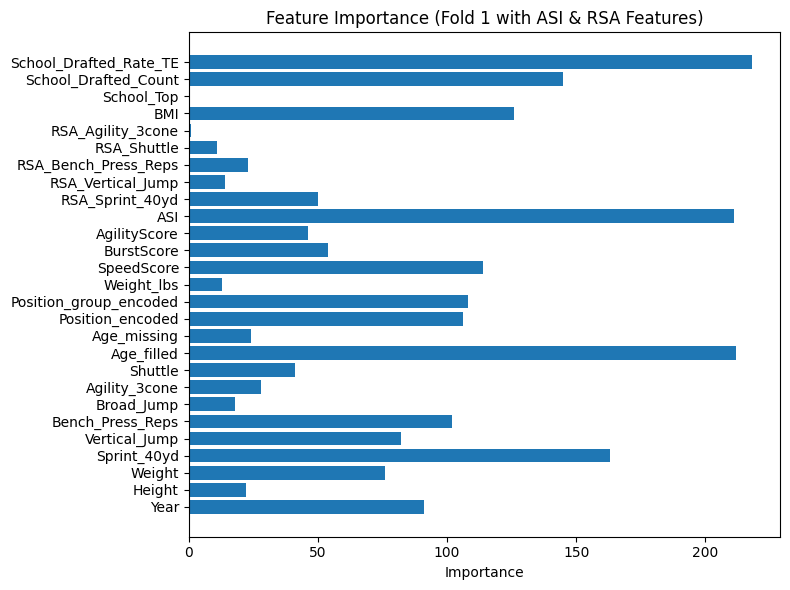

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2730
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# ✅ 08モデルパラメータ固定
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns  # ✅ 対応する特徴量名
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 with ASI & RSA Features)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2251
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[166]	valid_0's auc: 0.862216	valid_0's binary_logloss: 0.409837
✅ Fold 1 - Train AUC: 0.8916, Validation AUC: 0.8622


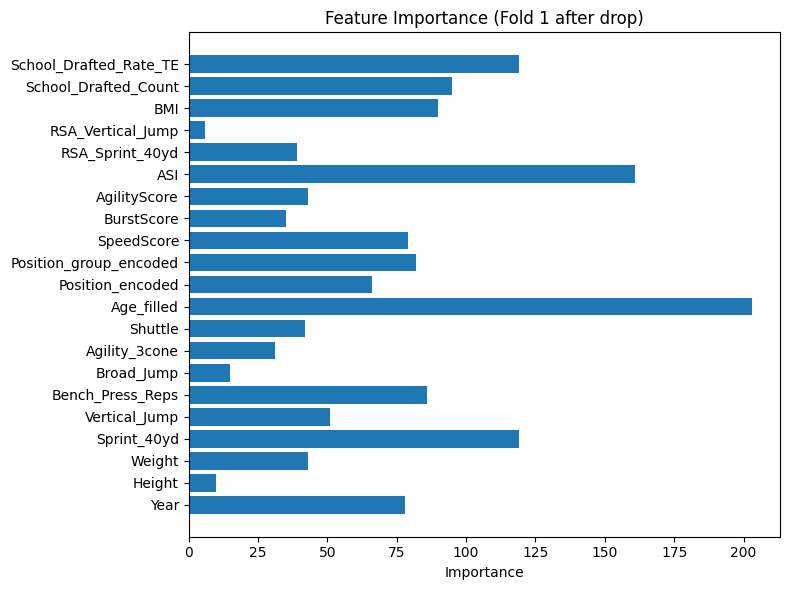

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2256
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[119]	valid_0's auc: 0.844622	valid_0's binary_logloss: 0.430819
✅ Fold 2 - Train AUC: 0.8919, Validation AUC: 0.8446
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the ove

In [38]:
# 不要カラムを削除
drop_cols = [
    "School_Top", "RSA_Agility_3cone", "RSA_Shuttle",
    "RSA_Bench_Press_Reps", "Weight_lbs", "Age_missing"
]

X_reduced = X.drop(columns=[col for col in drop_cols if col in X.columns])

# 再度モデルを定義
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced)):
    X_train, X_valid = X_reduced.iloc[train_idx], X_reduced.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 after drop)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

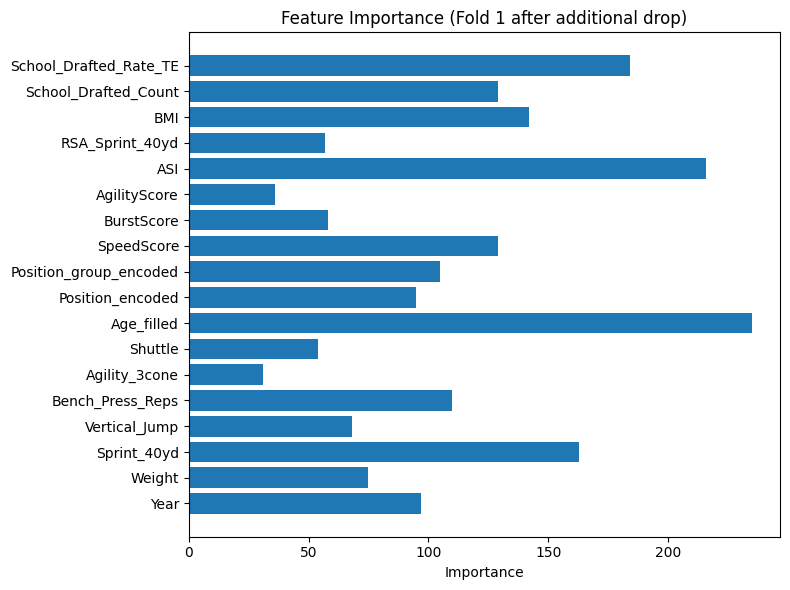

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [39]:
# 追加削除するカラム
drop_cols_additional = ["RSA_Vertical_Jump", "Broad_Jump", "Height"]

# すでに削除したカラムと合わせて削除
drop_cols_total = [
    "School_Top", "RSA_Agility_3cone", "RSA_Shuttle",
    "RSA_Bench_Press_Reps", "Weight_lbs", "Age_missing"
] + drop_cols_additional

# カラム削除
X_reduced2 = X.drop(columns=[col for col in drop_cols_total if col in X.columns])

# モデル定義（パラメータはそのまま）
model = LGBMClassifier(
    max_depth=6,
    num_leaves=10,
    min_child_samples=38,
    reg_alpha=8.18,
    reg_lambda=8.07,
    learning_rate=0.0442,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced2)):
    X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 after additional drop)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


In [41]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np

# Optuna objective
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "num_leaves": trial.suggest_int("num_leaves", 7, 31),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": 1000,
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "random_state": 42
    }
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []
    
    for train_idx, valid_idx in kf.split(X_reduced2, y):
        X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = LGBMClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="auc",
            callbacks=[
                lgb.early_stopping(stopping_rounds=30),
                lgb.log_evaluation(0)
            ]
        )
        
        y_valid_pred = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, y_valid_pred)
        aucs.append(auc)
    
    return np.mean(aucs)

# 実行
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("✅ Best AUC:", study.best_value)
print("✅ Best Params:", study.best_params)


[I 2025-06-28 14:20:29,169] A new study created in memory with name: no-name-c0cf2e8a-c2c0-402c-a409-582c07039be7
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's auc: 0.822255	valid_0's binary_logloss: 0.458019
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features:

[I 2025-06-28 14:20:29,381] Trial 0 finished with value: 0.8427918160303399 and parameters: {'max_depth': 7, 'num_leaves': 7, 'min_child_samples': 60, 'reg_alpha': 0.03075162850577351, 'reg_lambda': 0.017920617882499643, 'learning_rate': 0.09822234436123785, 'subsample': 0.8477953052179319, 'colsample_bytree': 0.6923453392869785}. Best is trial 0 with value: 0.8427918160303399.
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:29,738] Trial 1 finished with value: 0.8357845548902137 and parameters: {'max_depth': 3, 'num_leaves': 12, 'min_child_samples': 75, 'reg_alpha': 3.152286661083857, 'reg_lambda': 0.013307934997255239, 'learning_rate': 0.032681832374689086, 'subsample': 0.9856786247112163, 'colsample_bytree': 0.8555799836018052}. Best is trial 0 with value: 0.8427918160303399.


[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:29,985] Trial 2 finished with value: 0.8407855387698089 and parameters: {'max_depth': 3, 'num_leaves': 20, 'min_child_samples': 70, 'reg_alpha': 4.747798805570462, 'reg_lambda': 1.2147777874783356, 'learning_rate': 0.0939199945445959, 'subsample': 0.8085600847659056, 'colsample_bytree': 0.8764134216

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:30,212] Trial 3 finished with value: 0.840100547783571 and parameters: {'max_depth': 5, 'num_leaves': 13, 'min_child_samples': 80, 'reg_alpha': 0.012798396160019, 'reg_lambda': 0.678099380216639, 'learning_rate': 0.0904364052894133, 'subsample': 0.8606941966185178, 'colsample_bytree': 0.875541960279

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:30,572] Trial 4 finished with value: 0.8343665944430191 and parameters: {'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 34, 'reg_alpha': 1.2088815251277905, 'reg_lambda': 7.878611698901331, 'learning_rate': 0.02451964321997276, 'subsample': 0.7335538735730397, 'colsample_bytree': 0.7868132880337455}. Best is trial 0 with value: 0.8427918160303399.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:30,819] Trial 5 finished with value: 0.8457090033257426 and parameters: {'max_depth': 4, 'num_leaves': 27, 'min_child_samples': 23, 'reg_alpha': 2.518790337368431, 'reg_lambda': 3.5225213158134383, 'learning_rate': 0.08908592065258464, 'subsample': 0.664946028291774, 'colsample_bytree': 0.6455923175

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:31,168] Trial 6 finished with value: 0.8369780056706254 and parameters: {'max_depth': 7, 'num_leaves': 22, 'min_child_samples': 67, 'reg_alpha': 7.127316742628957, 'reg_lambda': 2.3371677738370042, 'learning_rate': 0.09074213920632654, 'subsample': 0.6929721321992961, 'colsample_bytree': 0.7716665010186982}. Best is trial 5 with value: 0.8457090033257426.


[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:31,870] Trial 7 finished with value: 0.8355284315231881 and parameters: {'max_depth': 4, 'num_leaves': 10, 'min_child_samples': 80, 'reg_alpha': 3.7473440049511506, 'reg_lambda': 0.900652662390044, 'learning_rate': 0.015208889409828993, 'subsample': 0.7660268417920955, 'colsample_bytree': 0.7720955211080235}. Best is trial 5 with value: 0.8457090033257426.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:32,108] Trial 8 finished with value: 0.8509599349008727 and parameters: {'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 11, 'reg_alpha': 0.01880100142873508, 'reg_lambda': 0.011058851615715811, 'learning_rate': 0.09536057899152989, 'subsample': 0.8859378017622828, 'colsample_bytree': 0.8935781231149892}. Best is trial 8 with value: 0.8509599349008727.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:32,470] Trial 9 finished with value: 0.8395443363082856 and parameters: {'max_depth': 6, 'num_leaves': 25, 'min_child_samples': 44, 'reg_alpha': 0.8233206516689606, 'reg_lambda': 0.1646963193642798, 'learning_rate': 0.049844729697439076, 'subsample': 0.8324138950867828, 'colsample_bytree': 0.8623509

[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


Early stopping, best iteration is:
[24]	valid_0's auc: 0.831498	valid_0's binary_logloss: 0.451094
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[67]	valid_0's auc: 0.875531	valid_0's binary_logloss: 0.400047
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col

[I 2025-06-28 14:20:32,807] Trial 10 finished with value: 0.8496264476740338 and parameters: {'max_depth': 8, 'num_leaves': 16, 'min_child_samples': 12, 'reg_alpha': 0.10130062830120466, 'reg_lambda': 0.07265716235084592, 'learning_rate': 0.0691392952654582, 'subsample': 0.951692506720411, 'colsample_bytree': 0.9904329143952243}. Best is trial 8 with value: 0.8509599349008727.


Early stopping, best iteration is:
[74]	valid_0's auc: 0.860757	valid_0's binary_logloss: 0.393744
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[46]	valid_0's au

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:33,161] Trial 11 finished with value: 0.8484463789244655 and parameters: {'max_depth': 8, 'num_leaves': 17, 'min_child_samples': 11, 'reg_alpha': 0.08550677335525352, 'reg_lambda': 0.08051533322410839, 'learning_rate': 0.06886156390121029, 'subsample': 0.9407254826738372, 'colsample_bytree': 0.99256

[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


Early stopping, best iteration is:
[22]	valid_0's auc: 0.831548	valid_0's binary_logloss: 0.454496
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[59]	valid_0's auc: 0.874956	valid_0's binary_logloss: 0.404763
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You ca

[I 2025-06-28 14:20:33,583] Trial 12 finished with value: 0.8494870007097945 and parameters: {'max_depth': 8, 'num_leaves': 16, 'min_child_samples': 10, 'reg_alpha': 0.14585395894770534, 'reg_lambda': 0.04744822062326758, 'learning_rate': 0.06960220509411473, 'subsample': 0.918343453937326, 'colsample_bytree': 0.9981052185230777}. Best is trial 8 with value: 0.8509599349008727.


Early stopping, best iteration is:
[89]	valid_0's auc: 0.861168	valid_0's binary_logloss: 0.393546
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:33,931] Trial 13 finished with value: 0.8468102363823574 and parameters: {'max_depth': 5, 'num_leaves': 15, 'min_child_samples': 29, 'reg_alpha': 0.04002719367675242, 'reg_lambda': 0.03869700057822302, 'learning_rate': 0.06613592856318128, 'subsample': 0.9071879126598601, 'colsample_bytree': 0.94095

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:34,272] Trial 14 finished with value: 0.840183516495596 and parameters: {'max_depth': 4, 'num_leaves': 20, 'min_child_samples': 98, 'reg_alpha': 0.2492029837695489, 'reg_lambda': 0.27061646085254615, 'learning_rate': 0.05142453373296213, 'subsample': 0.9961084787618052, 'colsample_bytree': 0.9501602212743748}. Best is trial 8 with value: 0.8509599349008727.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:34,569] Trial 15 finished with value: 0.8420342981997117 and parameters: {'max_depth': 7, 'num_leaves': 8, 'min_child_samples': 46, 'reg_alpha': 0.0112612590330689, 'reg_lambda': 0.010240317726861937, 'learning_rate': 0.07834258062110351, 'subsample': 0.8878112273009983, 'colsample_bytree': 0.929395

[LightGBM] [Info] Total Bins 2167
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[79]	valid_0's auc: 0.855118	valid_0's binary_logloss: 0.411977
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:34,886] Trial 16 finished with value: 0.8498388904713103 and parameters: {'max_depth': 5, 'num_leaves': 13, 'min_child_samples': 21, 'reg_alpha': 0.04411208038135173, 'reg_lambda': 0.1312787735963712, 'learning_rate': 0.079814294037633, 'subsample': 0.6125771806242482, 'colsample_bytree': 0.9191029398220378}. Best is trial 8 with value: 0.8509599349008727.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),
[I 2025-06-28 14:20:35,169] Trial 17 finished with value: 0.8474861785754149 and parameters: {'max_depth': 5, 'num_leaves': 12, 'min_child_samples': 19, 'reg_alpha': 0.03194338094610905, 'reg_lambda': 0.027179890763457358, 'learning_rate': 0.07871763092960823, 'subsample': 0.6256985850169746, 'colsample_bytree': 0.8229

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[58]	valid_0's auc: 0.864138	valid_0's binary_logloss: 0.405983
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:35,478] Trial 18 finished with value: 0.8421549542112462 and parameters: {'max_depth': 4, 'num_leaves': 23, 'min_child_samples': 38, 'reg_alpha': 0.04875872073732313, 'reg_lambda': 0.1807580127928879, 'learning_rate': 0.08050245141240417, 'subsample': 0.7729601799461748, 'colsample_bytree': 0.9087460722649606}. Best is trial 8 with value: 0.8509599349008727.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[128]	valid_0's auc: 0.8607	valid_0's binary_logloss: 0.394947
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't 

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:36,003] Trial 19 finished with value: 0.853445023296626 and parameters: {'max_depth': 3, 'num_leaves': 14, 'min_child_samples': 24, 'reg_alpha': 0.016962408850397636, 'reg_lambda': 0.4295483322730569, 'learning_rate': 0.04190839851431542, 'subsample': 0.6121766032014228, 'colsample_bytree': 0.7242779056153535}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:36,345] Trial 20 finished with value: 0.8367480592990091 and parameters: {'max_depth': 3, 'num_leaves': 18, 'min_child_samples': 56, 'reg_alpha': 0.01774029004550804, 'reg_lambda': 0.4810684846923245, 'learning_rate': 0.04252052616069272, 'subsample': 0.7185678176646648, 'colsample_bytree': 0.7138907703290782}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:37,028] Trial 21 finished with value: 0.8416572865917444 and parameters: {'max_depth': 3, 'num_leaves': 14, 'min_child_samples': 21, 'reg_alpha': 0.025832463560708264, 'reg_lambda': 0.13317203972711542, 'learning_rate': 0.037155074038550444, 'subsample': 0.6014324557229004, 'colsample_bytree': 0.7259471626316326}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:37,526] Trial 22 finished with value: 0.849072660263054 and parameters: {'max_depth': 4, 'num_leaves': 10, 'min_child_samples': 27, 'reg_alpha': 0.06320076182487273, 'reg_lambda': 0.3554742434237072, 'learning_rate': 0.060151984091878816, 'subsample': 0.6577279932726751, 'colsample_bytree': 0.6039241121773661}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:38,092] Trial 23 finished with value: 0.8496112775673519 and parameters: {'max_depth': 5, 'num_leaves': 11, 'min_child_samples': 17, 'reg_alpha': 0.020696456583019756, 'reg_lambda': 1.5401723174385076, 'learning_rate': 0.08329699432438509, 'subsample': 0.6108744499137884, 'colsample_bytree': 0.8384960237261043}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:38,590] Trial 24 finished with value: 0.8425863561206853 and parameters: {'max_depth': 4, 'num_leaves': 14, 'min_child_samples': 35, 'reg_alpha': 0.19311107496187419, 'reg_lambda': 0.0951850039454553, 'learning_rate': 0.056879746994825175, 'subsample': 0.650635889203894, 'colsample_bytree': 0.90233738479698}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:39,285] Trial 25 finished with value: 0.8424034269933557 and parameters: {'max_depth': 3, 'num_leaves': 9, 'min_child_samples': 43, 'reg_alpha': 0.011497350689099439, 'reg_lambda': 0.02340991768951209, 'learning_rate': 0.04557593393078506, 'subsample': 0.6894628032816678, 'colsample_bytree': 0.7385339785584301}. Best is trial 19 with value: 0.853445023296626.
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:40,190] Trial 26 finished with value: 0.8490901288066899 and parameters: {'max_depth': 6, 'num_leaves': 18, 'min_child_samples': 27, 'reg_alpha': 0.5498575155470704, 'reg_lambda': 0.30354736449004116, 'learning_rate': 0.02943178796811683, 'subsample': 0.742785057355499, 'colsample_bytree': 0.8140162855447716}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:40,612] Trial 27 finished with value: 0.8523442299357417 and parameters: {'max_depth': 5, 'num_leaves': 13, 'min_child_samples': 16, 'reg_alpha': 0.06612644261969587, 'reg_lambda': 0.042851119530054056, 'learning_rate': 0.09641074986203751, 'subsample': 0.6313606637225593, 'colsample_bytree': 0.6693153138508985}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:41,245] Trial 28 finished with value: 0.8525574274030943 and parameters: {'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 16, 'reg_alpha': 0.09911434038932929, 'reg_lambda': 0.04216984202770095, 'learning_rate': 0.09929162050900987, 'subsample': 0.8077847536926374, 'colsample_bytree': 0.6673923076110732}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:41,659] Trial 29 finished with value: 0.8439583553785177 and parameters: {'max_depth': 3, 'num_leaves': 7, 'min_child_samples': 51, 'reg_alpha': 0.41233711796552536, 'reg_lambda': 0.04388612858124817, 'learning_rate': 0.09804029964351384, 'subsample': 0.8016491087416782, 'colsample_bytree': 0.6657115210116916}. Best is trial 19 with value: 0.853445023296626.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.81962	valid_0's binary_logloss: 0.622705
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 1

[I 2025-06-28 14:20:42,305] Trial 30 finished with value: 0.8361167797433626 and parameters: {'max_depth': 6, 'num_leaves': 19, 'min_child_samples': 29, 'reg_alpha': 0.09307852685414574, 'reg_lambda': 0.02532252573837689, 'learning_rate': 0.012794304698152889, 'subsample': 0.6992140949467315, 'colsample_bytree': 0.6766148307956328}. Best is trial 19 with value: 0.853445023296626.


Early stopping, best iteration is:
[3]	valid_0's auc: 0.799072	valid_0's binary_logloss: 0.638586
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.827679	valid_0's binary_logloss: 0.60512
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total B

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:42,800] Trial 31 finished with value: 0.8541529908006957 and parameters: {'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 14, 'reg_alpha': 0.019751866167187333, 'reg_lambda': 0.017301323734467158, 'learning_rate': 0.09631834340894883, 'subsample': 0.8574894975166423, 'colsample_bytree': 0.6298870695394214}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:43,315] Trial 32 finished with value: 0.8540279970216655 and parameters: {'max_depth': 4, 'num_leaves': 12, 'min_child_samples': 16, 'reg_alpha': 0.06065218596235763, 'reg_lambda': 0.018381506962622633, 'learning_rate': 0.08433387850534386, 'subsample': 0.8350134294667361, 'colsample_bytree': 0.6270781523243097}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[60]	valid_0's auc: 0.866198	valid_0's binary_logloss: 0.406476
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:43,711] Trial 33 finished with value: 0.8499425242786935 and parameters: {'max_depth': 3, 'num_leaves': 11, 'min_child_samples': 17, 'reg_alpha': 0.15239816299611572, 'reg_lambda': 0.01631916918092994, 'learning_rate': 0.09952804795704262, 'subsample': 0.836678827194004, 'colsample_bytree': 0.6124715907275109}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2025-06-28 14:20:44,271] Trial 34 finished with value: 0.8496734739779853 and parameters: {'max_depth': 4, 'num_leaves': 16, 'min_child_samples': 23, 'reg_alpha': 0.029893202473470288, 'reg_lambda': 0.016822921282336954, 'learning_rate': 0.08469208052939955, 'subsample': 0.8639976722098028, 'colsample_bytree': 0.6325447393511818}. Best is trial 31 with value: 0.8541529908006957.
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:44,860] Trial 35 finished with value: 0.8512775939269807 and parameters: {'max_depth': 3, 'num_leaves': 12, 'min_child_samples': 32, 'reg_alpha': 0.01633383838994414, 'reg_lambda': 0.028763240939296962, 'learning_rate': 0.08654298634070327, 'subsample': 0.7844484210827076, 'colsample_bytree': 0.6944880594692842}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:45,383] Trial 36 finished with value: 0.8518407952356309 and parameters: {'max_depth': 3, 'num_leaves': 14, 'min_child_samples': 16, 'reg_alpha': 0.05523857488141299, 'reg_lambda': 0.06313220130689358, 'learning_rate': 0.07483082333997965, 'subsample': 0.8503656490254164, 'colsample_bytree': 0.6384981366697614}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:45,753] Trial 37 finished with value: 0.8421933693038264 and parameters: {'max_depth': 4, 'num_leaves': 17, 'min_child_samples': 39, 'reg_alpha': 0.026943614263327077, 'reg_lambda': 0.01566413075593923, 'learning_rate': 0.09166375936836922, 'subsample': 0.826575236050318, 'colsample_bytree': 0.6977003612388737}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:46,603] Trial 38 finished with value: 0.8518823851367381 and parameters: {'max_depth': 4, 'num_leaves': 21, 'min_child_samples': 25, 'reg_alpha': 0.10987589891840015, 'reg_lambda': 0.7039798526166827, 'learning_rate': 0.03888401653801806, 'subsample': 0.8046574504343704, 'colsample_bytree': 0.7443793711292171}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:47,362] Trial 39 finished with value: 0.8366860733745873 and parameters: {'max_depth': 3, 'num_leaves': 10, 'min_child_samples': 62, 'reg_alpha': 0.32703696152564254, 'reg_lambda': 0.020727748550360633, 'learning_rate': 0.02217177888332795, 'subsample': 0.7467752199517492, 'colsample_bytree': 0.6495032884507455}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-06-28 14:20:47,844] Trial 40 finished with value: 0.8396446310252207 and parameters: {'max_depth': 5, 'num_leaves': 29, 'min_child_samples': 93, 'reg_alpha': 0.014584753578192132, 'reg_lambda': 0.012678323856085923, 'learning_rate': 0.0927153703796301, 'subsample': 0.8670489182225471, 'colsample_bytree': 0.6153280137093573}. Best is trial 31 with value: 0.8541529908006957.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	valid_0's auc: 0.837611	valid_0's binary_logloss: 0.434071
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-06-28 14:20:48,387] Trial 41 finished with value: 0.8548009658085836 and parameters: {'max_depth': 5, 'num_leaves': 13, 'min_child_samples': 14, 'reg_alpha': 0.07015249612522008, 'reg_lambda': 0.034389307097333704, 'learning_rate': 0.09981661386729596, 'subsample': 0.8204821827010891, 'colsample_bytree': 0.6649408231107803}. Best is trial 41 with value: 0.8548009658085836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[64]	valid_0's auc: 0.864152	valid_0's binary_logloss: 0.40293
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000434 seconds.
You can set `force_col_wise=true` to remove the overhea

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:48,760] Trial 42 finished with value: 0.8523723004010895 and parameters: {'max_depth': 4, 'num_leaves': 12, 'min_child_samples': 14, 'reg_alpha': 0.010029605516261256, 'reg_lambda': 0.029897090276622375, 'learning_rate': 0.0997241034769311, 'subsample': 0.8196367120920095, 'colsample_bytree': 0.6511362647802151}. Best is trial 41 with value: 0.8548009658085836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:49,312] Trial 43 finished with value: 0.8546805622597076 and parameters: {'max_depth': 4, 'num_leaves': 15, 'min_child_samples': 10, 'reg_alpha': 0.040118081178116265, 'reg_lambda': 0.06324343743481022, 'learning_rate': 0.08802338789009953, 'subsample': 0.7868693352508123, 'colsample_bytree': 0.626221434379643}. Best is trial 41 with value: 0.8548009658085836.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2025-06-28 14:20:49,839] Trial 44 finished with value: 0.8499062563266658 and parameters: {'max_depth': 5, 'num_leaves': 14, 'min_child_samples': 11, 'reg_alpha': 0.03704100206087297, 'reg_lambda': 9.347984791291454, 'learning_rate': 0.0877001889667983, 'subsample': 0.8817257504011603, 'colsample_bytree': 0.6202042039049604}. Best is trial 41 with value: 0.8548009658085836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[69]	valid_0's auc: 0.857596	valid_0's binary_logloss: 0.398828
[

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[74]	valid_0's auc: 0.88539	valid_0's binary_logloss: 0.397334
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2167
[LightGBM] [Info] Number of data point

[I 2025-06-28 14:20:50,224] Trial 45 finished with value: 0.8523589524949834 and parameters: {'max_depth': 4, 'num_leaves': 17, 'min_child_samples': 21, 'reg_alpha': 0.02077611080730339, 'reg_lambda': 0.09996491335472933, 'learning_rate': 0.09275729346927347, 'subsample': 0.7829020978522481, 'colsample_bytree': 0.6289476256299922}. Best is trial 41 with value: 0.8548009658085836.
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "re

[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2025-06-28 14:20:50,823] Trial 46 finished with value: 0.8476248442945613 and parameters: {'max_depth': 5, 'num_leaves': 11, 'min_child_samples': 32, 'reg_alpha': 2.029181044821383, 'reg_lambda': 0.060822282869373565, 'learning_rate': 0.07505377465989536, 'subsample': 0.8454229453918309, 'colsample_bytree': 0.6887603742647053}. Best is trial 41 with value: 0.8548009658085836.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[90]	valid_0's auc: 0.863087	valid_0's binary_logloss: 0.401598
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[35]	valid_0's auc: 0.833018	valid_0's binary_logloss: 0.445621
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [I

[I 2025-06-28 14:20:51,328] Trial 47 finished with value: 0.8538486410261242 and parameters: {'max_depth': 6, 'num_leaves': 9, 'min_child_samples': 12, 'reg_alpha': 0.062209877433677806, 'reg_lambda': 2.9581523698277006, 'learning_rate': 0.08824080333581476, 'subsample': 0.9426469473809426, 'colsample_bytree': 0.6517460913591101}. Best is trial 41 with value: 0.8548009658085836.


Early stopping, best iteration is:
[125]	valid_0's auc: 0.829521	valid_0's binary_logloss: 0.43379
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[73]	valid_0's auc: 0.860813	valid_0's binary_logloss: 0.395041
[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total

C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648090 -> initscore=0.610654
[LightGBM] [Info] Start training from score 0.610654
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[118]	valid_0's auc: 0.880276	valid_0's binary_logloss: 0.394466
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2167
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features

[I 2025-06-28 14:20:51,836] Trial 48 finished with value: 0.853265332093488 and parameters: {'max_depth': 7, 'num_leaves': 8, 'min_child_samples': 10, 'reg_alpha': 0.06659365552380422, 'reg_lambda': 3.1841059535572107, 'learning_rate': 0.08841856922132019, 'subsample': 0.9578132602395399, 'colsample_bytree': 0.6013460963865703}. Best is trial 41 with value: 0.8548009658085836.


Early stopping, best iteration is:
[185]	valid_0's auc: 0.826573	valid_0's binary_logloss: 0.438178
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[118]	valid_0's auc: 0.862642	valid_0's binary_logloss: 0.391612


C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 10.0),
C:\Users\81807\AppData\Local\Temp\ipykernel_12136\3838853000.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 10.0),


[LightGBM] [Info] Number of positive: 1442, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648381 -> initscore=0.611932
[LightGBM] [Info] Start training from score 0.611932
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.822517	valid_0's binary_logloss: 0.554567
[LightGBM] [Info] Number of positive: 1442, number of negative: 783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2161
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 

[I 2025-06-28 14:20:52,293] Trial 49 finished with value: 0.8403919754562811 and parameters: {'max_depth': 6, 'num_leaves': 7, 'min_child_samples': 14, 'reg_alpha': 9.39908817224008, 'reg_lambda': 0.03417214853192983, 'learning_rate': 0.08425789709329344, 'subsample': 0.9208799242479866, 'colsample_bytree': 0.6529213391947463}. Best is trial 41 with value: 0.8548009658085836.


[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2153
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.648539 -> initscore=0.612625
[LightGBM] [Info] Start training from score 0.612625
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's auc: 0.805286	valid_0's binary_logloss: 0.492082
[LightGBM] [Info] Number of positive: 1443, number of negative: 782
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2163
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features:

[LightGBM] [Info] Number of positive: 1445, number of negative: 779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2136
[LightGBM] [Info] Number of data points in the train set: 2224, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.649730 -> initscore=0.617854
[LightGBM] [Info] Start training from score 0.617854
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

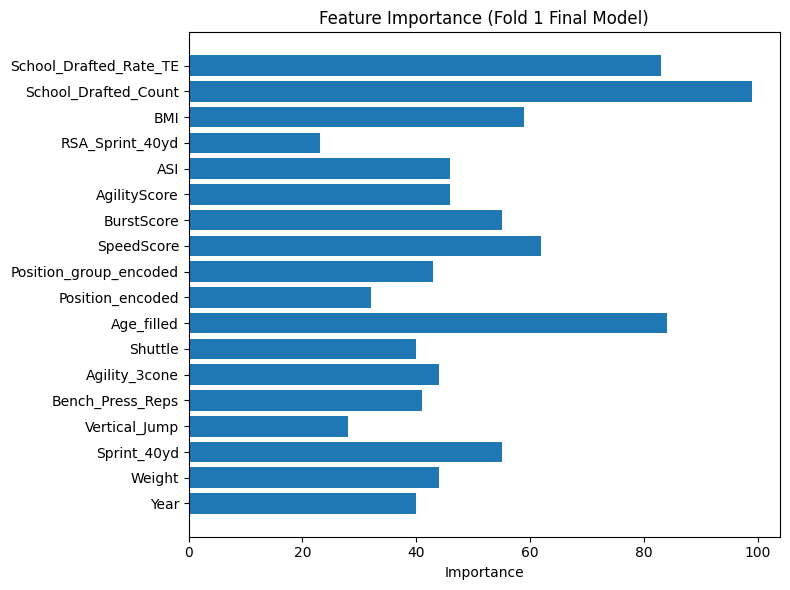

[LightGBM] [Info] Number of positive: 1448, number of negative: 777
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 2225, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.650787 -> initscore=0.622498
[LightGBM] [Info] Start training from score 0.622498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [42]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Optunaで得たパラメータ
best_params = {
    'max_depth': 5,
    'num_leaves': 13,
    'min_child_samples': 14,
    'reg_alpha': 0.07015249612522008,
    'reg_lambda': 0.034389307097333704,
    'learning_rate': 0.09981661386729596,
    'subsample': 0.8204821827010891,
    'colsample_bytree': 0.6649408231107803,
    'n_estimators': 1000,
    'random_state': 42
}

model = LGBMClassifier(**best_params)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_aucs = []
val_aucs = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X_reduced2)):
    X_train, X_valid = X_reduced2.iloc[train_idx], X_reduced2.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=30),
            lgb.log_evaluation(0)
        ]
    )

    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_valid_pred = model.predict_proba(X_valid)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    val_auc = roc_auc_score(y_valid, y_valid_pred)

    train_aucs.append(train_auc)
    val_aucs.append(val_auc)

    print(f"✅ Fold {fold + 1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")

    if fold == 0:
        importances = model.feature_importances_
        feature_names = X_train.columns
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names, importances)
        plt.title("Feature Importance (Fold 1 Final Model)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

print(f"\n✅ Average Train AUC: {np.mean(train_aucs):.4f}")
print(f"✅ Average Validation AUC: {np.mean(val_aucs):.4f}")


In [44]:
# 🔄 提出用ファイルの作成処理（LightGBMモデルに基づく予測）

# original_test を再読み込みして Id を復元
original_test = pd.read_csv(PATH + "test.csv")

# 提出用特徴量列は X_reduced2.columns で確定させる
feature_cols = X_reduced2.columns.tolist()

# test に存在しない列があれば埋める（安全）
missing_cols = set(feature_cols) - set(test.columns)
for col in missing_cols:
    test[col] = 0

# 列順を揃える
X_test = test[feature_cols]

# 予測
y_pred = model.predict_proba(X_test)[:, 1]


# 提出用DataFrameを作成
submission = pd.DataFrame({
    "Id": original_test["Id"],
    "Drafted": y_pred
})

# 保存ディレクトリをプロジェクトルートに作成
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
save_dir = os.path.join(root_dir, "submissions")
os.makedirs(save_dir, exist_ok=True)

import os
import datetime
import re  # ← これを忘れずに！

try:
    import ipynbname
    notebook_path = ipynbname.path()
    notebook_name = notebook_path.stem  # ファイル名（拡張子なし）
except:
    notebook_name = "11_0628_notebook()"   # fallback

# 数字とアンダースコア部分だけ抽出（例：06_0627）
match = re.search(r"\d{2}_\d{4}", notebook_name)
tag = match.group() if match else notebook_name

filename = f"submission_{tag}.csv"


# 提出ファイル名を組み立てる
filename = f"submission_{tag}.csv"
save_path = os.path.join(save_dir, filename)

# 書き出し
submission.to_csv(save_path, index=False)
print(f"✅ 提出ファイルを保存しました: {save_path}")

✅ 提出ファイルを保存しました: c:\Users\81807\Desktop\Kaggle\GCI②(NFL Draft Prediction)\submissions\submission_11_0628.csv
